<h1><center> Final Project Source Code </center></h1>
<center>Juhi Choubey</center>
<center>12/12/2022</center>

### Import Libraries
In this cell, we import all the libraries that are required in this source code.

In [25]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_context('talk', font_scale = 1.05)

### Step 1: Load Data
We will now import all the datasets - both from Kaggle & Redfin - that are necessary for our analysis. Additionally, we will also declare all the needed constants such as county & state initials, start-end date of the analysis, and the given population of the county for our project.

In [26]:
# Import Datasets
df_confirmed_cases = pd.read_csv('RAW_us_confirmed_cases.csv')
df_mask_mandate = pd.read_csv('masking_mandates_by_county.csv')
df_market_tracker = pd.read_csv('county_market_tracker.tsv', sep = '\t')
df_housing_data = pd.read_csv('weekly_housing_market_data_most_recent.tsv', sep = '\t')
df_interest_rates = pd.read_excel('weekly_interest_rate.xlsx')

# Specify Constants
county, state = 'Multnomah', 'Oregon'
fips_list = ['41051']
population_apr20, population_jul21 = 815428, 803377
start_date, end_date = '2020-02-01', '2021-10-01'

### Step 2: Data Cleaning
At this step, we will prepare all the imported datasets for our analysis. This will include filtering for required area and time-frame, selecting only required columns, and condensing or melting rows at weekly level. Once done, we shall proceed to merge/join all teh necessary dataframes into a single dataframe.

**(a.) df_confirmed_cases**

In [27]:
# Drop unecessary columns & rename needed
df_confirmed_cases.drop(columns = ['UID','iso2','iso3','code3','Country_Region','Combined_Key','Lat','Long_'], inplace = True)
df_confirmed_cases.rename(columns = {'Province_State': 'state', 'Admin2': 'county', 'FIPS': 'fips_county'}, inplace = True)

# Process rows: remove nulls, filter, un-pivot & reset index
df_confirmed_cases.dropna(subset = ['fips_county'], inplace = True)
df_confirmed_cases.fips_county = df_confirmed_cases.fips_county.astype('int').astype('str')
df_confirmed_cases = df_confirmed_cases[df_confirmed_cases.fips_county.isin(fips_list)]
df_confirmed_cases.reset_index(drop = True, inplace = True)

id_vars = ['state','county','fips_county']
df_confirmed_cases = pd.melt(df_confirmed_cases, id_vars = id_vars, var_name = 'date', value_name = 'case_count')
df_confirmed_cases.date = pd.to_datetime(df_confirmed_cases.date)
df_confirmed_cases = df_confirmed_cases[(df_confirmed_cases['date'] >= start_date) & (df_confirmed_cases['date'] <= end_date)]
df_confirmed_cases.reset_index(drop = True, inplace = True)

# Drop unecessary columns & sort
df_confirmed_cases = df_confirmed_cases[['date','case_count']]
df_confirmed_cases.tail()

,date,case_count
604,2021-09-27,52543
605,2021-09-28,52638
606,2021-09-29,52822
607,2021-09-30,53026
608,2021-10-01,53193


In [28]:
# Aggregate to weekly level
df_confirmed_cases_weekly = df_confirmed_cases.resample('W', on='date').sum().reset_index()
df_confirmed_cases_weekly.rename(columns={"date": "period_end"}, inplace=True)
df_confirmed_cases_weekly['period_begin'] = df_confirmed_cases_weekly['period_end']-pd.DateOffset(days=6)
df_confirmed_cases_weekly = df_confirmed_cases_weekly[['period_begin', 'period_end', 'case_count']]
df_confirmed_cases_weekly['population'] = df_confirmed_cases_weekly['period_begin'].apply(lambda x: 
                                                                    population_apr20 if x < datetime.strptime('2021-07-01', 
                                                                                                              '%Y-%m-%d') 
                                                                    else population_jul21)

df_confirmed_cases_weekly.tail()

,period_begin,period_end,case_count,population
83,2021-08-30,2021-09-05,334081,803377
84,2021-09-06,2021-09-12,343542,803377
85,2021-09-13,2021-09-19,353849,803377
86,2021-09-20,2021-09-26,362258,803377
87,2021-09-27,2021-10-03,264222,803377


In [29]:
# Extract features: Infection Rate, Change in Infection Rate
df_confirmed_cases_weekly.sort_values(by = 'period_begin', inplace = True)
df_confirmed_cases_weekly['delta_over_last'] = df_confirmed_cases_weekly['case_count'] - df_confirmed_cases_weekly['case_count'].shift(1).fillna(0)
df_confirmed_cases_weekly['infection_rate'] = df_confirmed_cases_weekly['case_count'] / (df_confirmed_cases_weekly['population'] - df_confirmed_cases_weekly['case_count'])

# Extract increase in infection rate (current - previous) count
df_confirmed_cases_weekly.sort_values(by = 'period_begin', inplace = True)
df_confirmed_cases_weekly.tail()

,period_begin,period_end,case_count,population,delta_over_last,infection_rate
83,2021-08-30,2021-09-05,334081,803377,10528.0,0.711877
84,2021-09-06,2021-09-12,343542,803377,9461.0,0.747098
85,2021-09-13,2021-09-19,353849,803377,10307.0,0.787157
86,2021-09-20,2021-09-26,362258,803377,8409.0,0.821225
87,2021-09-27,2021-10-03,264222,803377,-98036.0,0.490067


**(b.) df_mask_mandate**

In [30]:
# Process rows: filter & reset index
df_mask_mandate['County_Name'] = df_mask_mandate['County_Name'].str.rstrip('County ')
df_mask_mandate = df_mask_mandate[df_mask_mandate['County_Name'].isin([county])]
df_mask_mandate.date = pd.to_datetime(df_mask_mandate.date)
df_mask_mandate = df_mask_mandate[(df_mask_mandate['date'] >= start_date) & (df_mask_mandate['date'] <= end_date)]
df_mask_mandate.reset_index(drop = True, inplace = True)

# Process columns: create new cols & convert datatypes
def policy(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return -1
    
df_mask_mandate['mask_mandate'] = df_mask_mandate['Face_Masks_Required_in_Public'].apply(lambda x: policy(x))
df_mask_mandate['fips_county'] = df_mask_mandate['FIPS_State'].astype('str')+'0'+df_mask_mandate['FIPS_County'].astype('str')

# Drop unecessary columns & sort
df_mask_mandate.drop(columns = ['State_Tribe_Territory',
                                'FIPS_State',
                                'County_Name',
                                'FIPS_County',
                                'URL',
                                'Citation',
                                'order_code', 
                                'Face_Masks_Required_in_Public',
                                'Source_of_Action',
                                'fips_county'], inplace = True)
df_mask_mandate = df_mask_mandate[['date', 'mask_mandate']]
df_mask_mandate.head()

,date,mask_mandate
0,2020-04-11,-1
1,2020-04-12,-1
2,2020-04-13,-1
3,2020-04-10,-1
4,2020-04-14,-1


**(c.) df_interest_rates**

In [31]:
df_interest_rates = df_interest_rates[df_interest_rates['date'] >= '2020-02-01']
df_interest_rates.reset_index(drop = True, inplace = True)
df_interest_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           95 non-null     datetime64[ns]
 1   interest_rate  95 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB


**(d.) df_housing_data**

In [32]:
# Process rows: filter & reset index
df_housing_data = df_housing_data[df_housing_data["region_name"].str.contains('Multnomah County, OR')]
df_housing_data = df_housing_data[df_housing_data['duration'] == '1 weeks']
df_housing_data.reset_index(drop = True, inplace = True)

# Drop unecessary columns & sort
df_housing_data = df_housing_data[['period_begin',
                                   'period_end',
                                   'inventory',
                                   'total_homes_sold', 
                                   'median_sale_price',
                                   'median_new_listing_price',
                                   'total_new_listings']]

df_housing_data.head()

,period_begin,period_end,inventory,total_homes_sold,median_sale_price,median_new_listing_price,total_new_listings
0,2018-04-09,2018-04-15,1694.0,202.0,409500.0,449250.0,312.0
1,2020-09-28,2020-10-04,1753.0,307.0,490000.0,474950.0,330.0
2,2021-03-29,2021-04-04,1063.0,237.0,500000.0,494975.0,296.0
3,2020-12-14,2020-12-20,1172.0,256.0,454000.0,420000.0,137.0
4,2021-04-26,2021-05-02,1101.0,284.0,485000.0,479950.0,330.0


**Note:** Before proceeding to filter teh housing data for required time-frame, let us take a look at the overall trend. This will include the trend before strike of covid-19 and help us understand the difference in behavior.

Once this is done, we shall proceed to filter the housing data for required time-frame and merge with the rest of the datasets.

### Step 3: Visualizations

In [33]:
# Specify alternate time-frame
start_date = '2019-02-01'

# Filter the housing data for alternate time-frame
df_housing_data['period_begin'] = pd.to_datetime(df_housing_data['period_begin'])
df_housing_data['period_end'] = pd.to_datetime(df_housing_data['period_end'])
df_housing_data = df_housing_data[(df_housing_data["period_begin"] >= start_date) & (df_housing_data["period_end"] <= end_date)]
df_housing_data = df_housing_data.sort_values(["period_begin", "period_end"], ascending = (True, True))
df_housing_data.reset_index(drop = True, inplace = True)

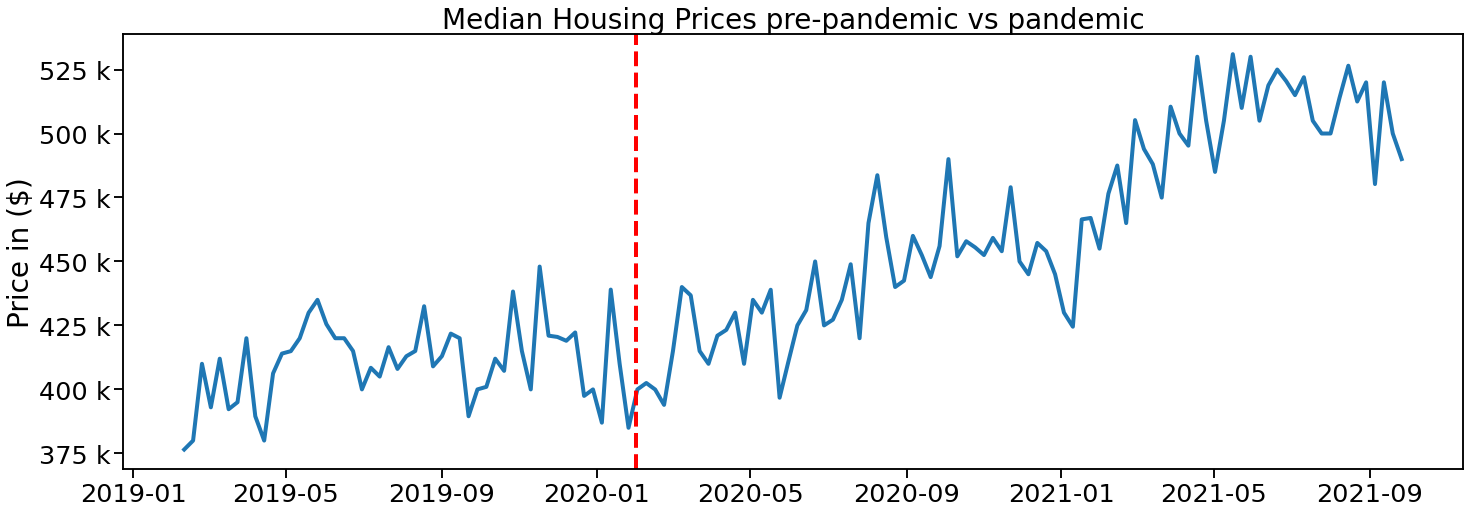

In [36]:
# Plot the trend chart to view Median Housing Prices ($) using seaborn

sns.set_context(context = 'talk', font_scale = 1.55)
fig = plt.subplots(figsize = (24,8))
g = sns.lineplot(x = 'period_end', y = 'median_sale_price', color = '#1f77b4', linewidth = 4, data = df_housing_data)
g.set(title = 'Median Housing Prices pre-pandemic vs pandemic', xlabel = '', ylabel = 'Price in ($)')

d = datetime.strptime('2020-02-01', '%Y-%m-%d')
plt.axvline(d, color = 'red', linestyle = '--', linewidth = 4)

g.yaxis.set_major_formatter(ticker.EngFormatter())

plt.savefig('Trend of Median Housing Prices for Multnomah, OR from 2019-01-01 to 2021-10-01.jpg')

plt.show()

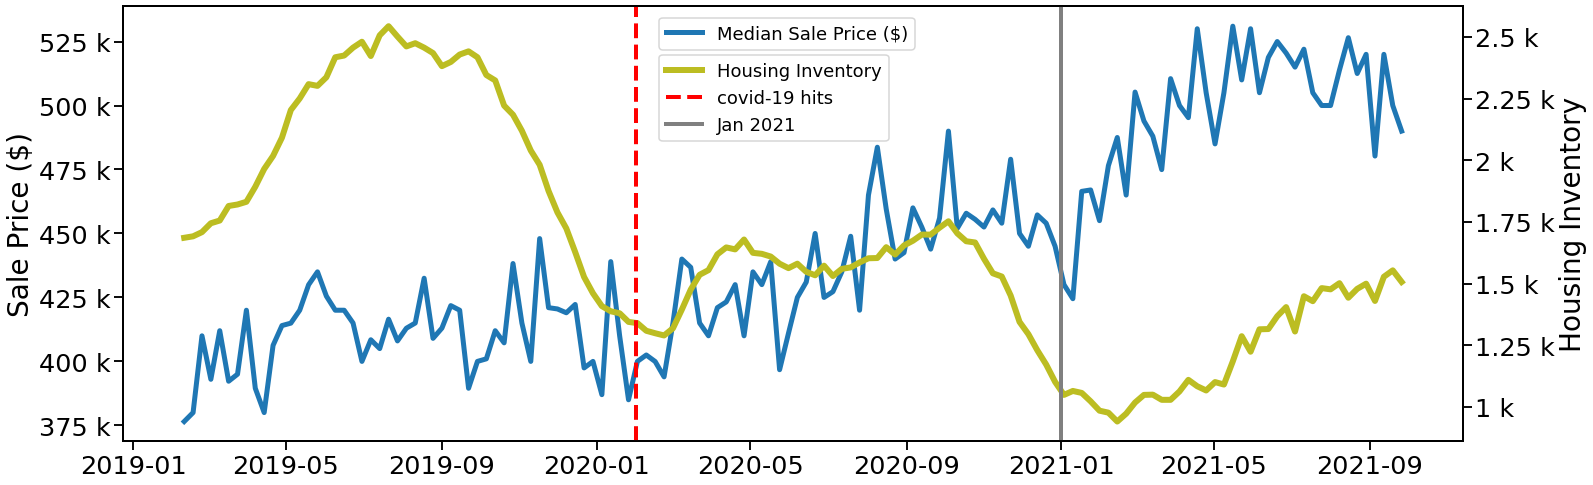

In [37]:
# Plot the trend chart to view total Housing Inventory along with Median Housing Prices ($) using seaborn.
# Also include highlighters for important times such as strike of covid-19 & strike of omnicron variant.

sns.set_context(context = 'talk', font_scale = 1.55)
fig, ax1 = plt.subplots(figsize = (24,8))
ax1 = plt.gca()
ax2 = ax1.twinx()

g = sns.lineplot(x = 'period_end', y = 'median_sale_price', data = df_housing_data,
                 color = '#1f77b4', linewidth = 5, label = 'Median Sale Price ($)', ax = ax1)
g.yaxis.set_major_formatter(ticker.EngFormatter())
ax1.set_xlabel('')
ax1.set_ylabel('Sale Price ($)')
ax1.legend(loc=(0.4, 0.9), fontsize=18)

g = sns.lineplot(x = 'period_end', y = 'inventory', data = df_housing_data,
             color = '#bcbd22', linestyle = '-', linewidth = 6, label = 'Housing Inventory', ax = ax2)
ax2.set_ylabel('Housing Inventory')

g.yaxis.set_major_formatter(ticker.EngFormatter())

d = datetime.strptime('2020-02-01', '%Y-%m-%d')
plt.axvline(d, color = 'red', linestyle = '--', linewidth = 4, label = 'covid-19 hits')
d = datetime.strptime('2021-01-01', '%Y-%m-%d')
plt.axvline(d, color = 'gray', linestyle = '-', linewidth = 4, label = 'Jan 2021')
ax2.legend(loc= (0.4, 0.69), fontsize=18)

plt.savefig('Median Housing Prices and Housing Inventory for Multnomah, OR from 2019-01-01 to 2021-10-01.jpg')

plt.show()

**Observation:** The graph below presents the week-over-week trend of Median Housing Price ($) and Housing Inventory between 2019-21. The onset of covid-19 in Feb 2020 has been marked in red while another important time - the onset of Omnicron in Jan 2021 has been marked in gray. These timelines coincide with highly noticeable fluctuations in both Median Housing Prices & Housing Inventory - showing that in both these times, the median housing price sharply increases, while the housing inventory plummets. This is highly indicative of a connection between covid-19 surge times with fluctuations in the housing market.     

**Note:** We shall now filter the housing data for required time-frame (declared at the beginning) and continue to merge it with the remaining datasets for model-building exercise.

In [38]:
# Filtering for required-timeframe
start_date, end_date = '2020-02-01', '2021-10-01'

df_housing_data['period_begin'] = pd.to_datetime(df_housing_data['period_begin'])
df_housing_data['period_end'] = pd.to_datetime(df_housing_data['period_end'])
df_housing_data = df_housing_data[(df_housing_data["period_begin"] >= start_date) & (df_housing_data["period_end"] <= end_date)]
df_housing_data = df_housing_data.sort_values(["period_begin", "period_end"], ascending = (True, True))
df_housing_data.reset_index(drop = True, inplace = True)

# Drop unecessary columns & sort
df_housing_data = df_housing_data[['period_begin',
                                   'period_end',
                                   'inventory',
                                   'total_homes_sold', 
                                   'median_sale_price',
                                   'median_new_listing_price',
                                   'total_new_listings']]
df_housing_data.head()

,period_begin,period_end,inventory,total_homes_sold,median_sale_price,median_new_listing_price,total_new_listings
0,2020-02-03,2020-02-09,1309.0,160.0,402500.0,415000.0,184.0
1,2020-02-10,2020-02-16,1299.0,198.0,399950.0,415000.0,212.0
2,2020-02-17,2020-02-23,1290.0,178.0,393950.0,435450.0,190.0
3,2020-02-24,2020-03-01,1319.0,223.0,415000.0,405000.0,243.0
4,2020-03-02,2020-03-08,1395.0,193.0,440000.0,400000.0,291.0


**(e.) Merging all required datasets**

In [39]:
df_merged = pd.merge(df_housing_data, df_confirmed_cases_weekly, on = ['period_begin','period_end'], how = 'inner')
df_merged.head()

,period_begin,period_end,inventory,total_homes_sold,median_sale_price,median_new_listing_price,total_new_listings,case_count,population,delta_over_last,infection_rate
0,2020-02-03,2020-02-09,1309.0,160.0,402500.0,415000.0,184.0,0,815428,0.0,0.0
1,2020-02-10,2020-02-16,1299.0,198.0,399950.0,415000.0,212.0,0,815428,0.0,0.0
2,2020-02-17,2020-02-23,1290.0,178.0,393950.0,435450.0,190.0,0,815428,0.0,0.0
3,2020-02-24,2020-03-01,1319.0,223.0,415000.0,405000.0,243.0,0,815428,0.0,0.0
4,2020-03-02,2020-03-08,1395.0,193.0,440000.0,400000.0,291.0,0,815428,0.0,0.0


**Note:** We shall now proceed to investigate the trend in the housing market with respect to #confirmed covid-19 cases.

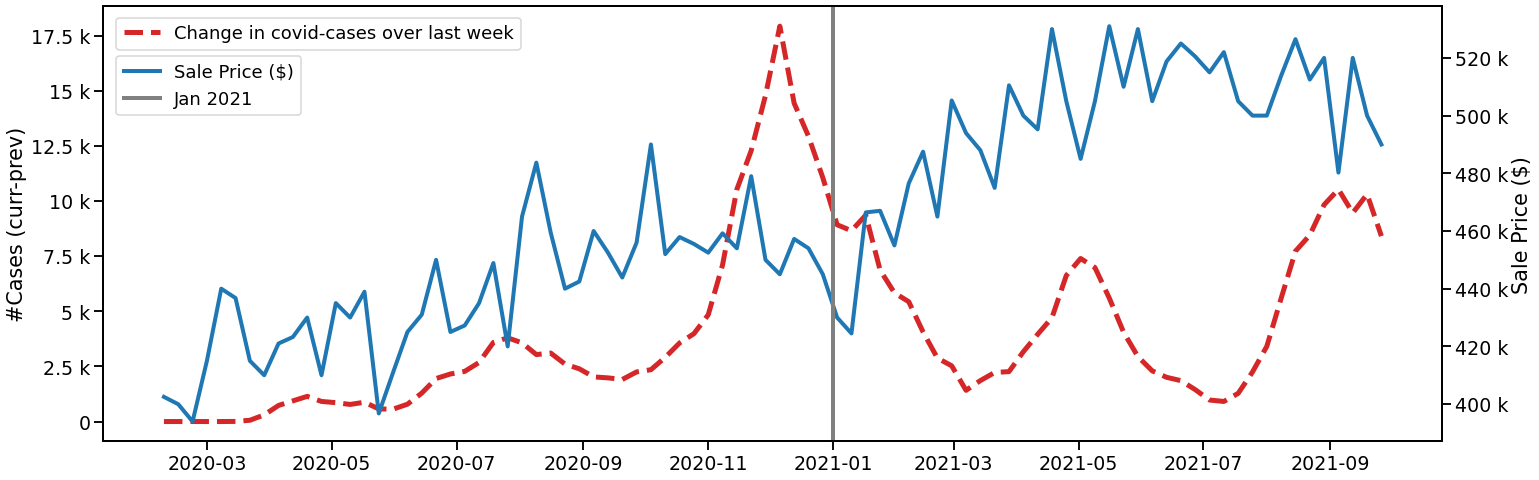

In [40]:
# Plot the trend chart to view difference in confirmed weekly cases along with Median Housing Prices ($) using seaborn.
# Also include highlighters for important times such as strike of covid-19 & strike of omnicron variant.

sns.set_context(context = 'talk', font_scale = 1.15)

fig, ax1 = plt.subplots(figsize = (24,8))

ax1 = plt.gca()
ax2 = ax1.twinx()

g= sns.lineplot(data = df_merged, x = 'period_end', y = 'delta_over_last', 
             color = '#d62728', linestyle = '--', linewidth = 5, label = 'Change in covid-cases over last week', ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('#Cases (curr-prev)')
ax1.legend(loc=(0.01, 0.9), fontsize=18)
g.yaxis.set_major_formatter(ticker.EngFormatter())

g = sns.lineplot(data = df_merged, x = 'period_end', y = 'median_sale_price', 
             color = '#1f77b4', linestyle = '-', linewidth = 4, label = 'Sale Price ($)', ax = ax2)
ax2.set_ylabel('Sale Price ($)')
d = datetime.strptime('2021-01-01', '%Y-%m-%d')
plt.axvline(d, color = 'gray', linestyle = '-', linewidth = 4, label = 'Jan 2021')

ax2.legend(loc= (0.01, 0.75), fontsize=18)
g.yaxis.set_major_formatter(ticker.EngFormatter())

plt.savefig('Median Housing Prices and Covid-19 Cases for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

plt.show()

**Observation:** The below graph builds up on the previous graph to highlight ‘how’ the covid-19 surge has affected the median housing prices. Instead of using the raw #confirmed cases, we proceed to pick an improved metric - week-over-week change in #confirmed cases - to observe any hidden patterns associated with the size of the covid-19 surge. The surge of Omnicron variant around Jan 2021 sees the most increase in weekly covid-19 cases. Interestingly enough, in both the previous and current graphs, we observe a considerable increase in Median Housing prices. Moreover, during this exact time, we also observe the total housing inventory plummeting so sharply that it completely shifts the overall trend.

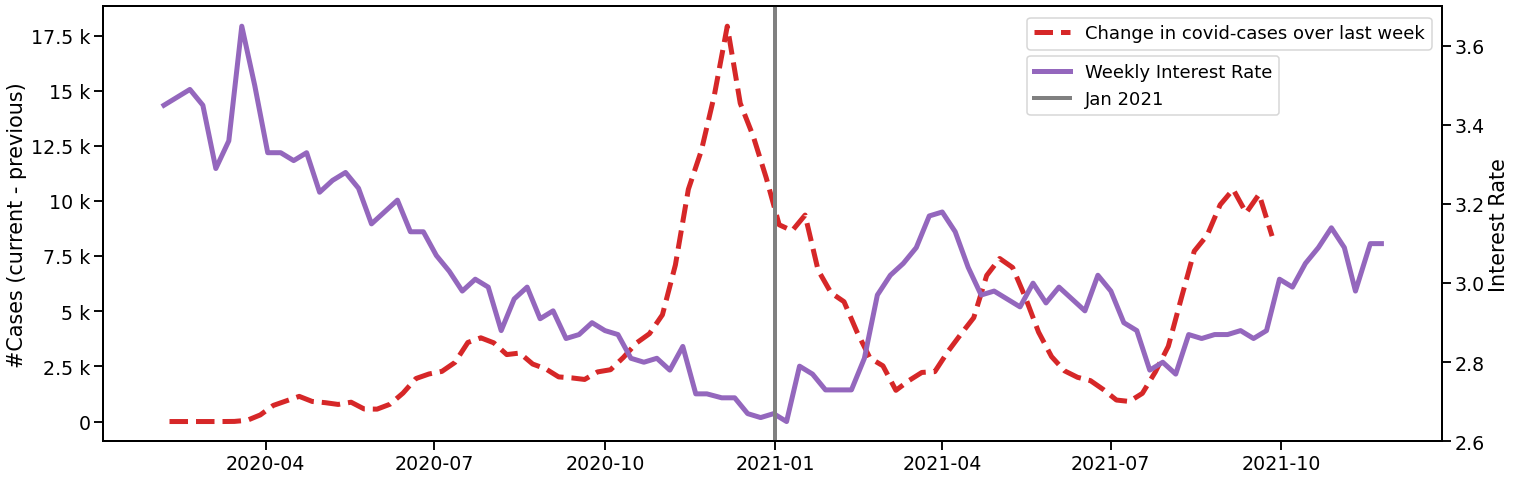

In [41]:
# Plot the trend chart to view difference in confirmed weekly cases along with Interest Rate using seaborn.
# Also include highlighters for important times such as strike of covid-19 & strike of omnicron variant.

sns.set_context(context = 'talk', font_scale = 1.15)

fig, ax1 = plt.subplots(figsize = (24,8))

ax1 = plt.gca()
ax2 = ax1.twinx()

g = sns.lineplot(data = df_merged, x = 'period_end', y = 'delta_over_last', 
             color = '#d62728', linestyle = '--', linewidth = 5, label = 'Change in covid-cases over last week', ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('#Cases (current - previous)')
ax1.legend(loc=(0.69, 0.9), fontsize=18)
g.yaxis.set_major_formatter(ticker.EngFormatter())

g = sns.lineplot(data = df_interest_rates, x = 'date', y = 'interest_rate', 
             color = '#9467bd', linestyle = '-', linewidth = 5, label = 'Weekly Interest Rate', ax = ax2)
ax2.set_ylabel('Interest Rate')
d = datetime.strptime('2021-01-01', '%Y-%m-%d')
plt.axvline(d, color = 'gray', linestyle = '-', linewidth = 4, label = 'Jan 2021')
ax2.legend(loc= (0.69, 0.75), fontsize=18)

plt.savefig('Interest Rates and Covid-19 Cases for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

plt.show()

**Observation:** We assessed the trend of interest rates as well during the set time to view if it fluctuated with rising and falling covid-19 cases. Until Jan 2021, while the covid-19 rose rapidly, there was a steady fall in the interest rates, however, it did begin recovering after Jan 2021 - after the highest increase in covid-19 cases was recorded. It can be seen that the interest rate sort of follows an inverse relationship with rising covid-19 cases through the graph below.

### Step 4: Model Building
This is the final step wherein we shall build an ARIMA model to infer the dependency of Median Housing Prices as a function on its auto-correlation component (lag 1) and #confirmed covid-19 cases.

In [44]:
from statsmodels.tsa.arima.model import ARIMA

# Set parameters of AR(1) process
ytimeseries = df_merged['median_sale_price']
xcovariates = df_merged[['case_count']]

# Build an ARIMA(p, d, q) model representing AR(1) process
ar1_model = ARIMA(endog = np.asarray(ytimeseries), 
                  order = (1, 0, 0),                         # AR(1) process
                  exog = np.asarray(xcovariates)).fit()

In [45]:
ar1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -959.274
Date:                Mon, 12 Dec 2022   AIC                           1926.549
Time:                        15:49:29   BIC                           1936.366
Sample:                             0   HQIC                          1930.500
                                 - 86                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.28e+05   5450.392     78.532      0.000    4.17e+05    4.39e+05
x1             0.2637      0.028      9.294      0.000       0.208       0.319
ar.L1          0.4948      0.098      5.046      0.000       0.303       0.687
sigma2      2.826e+08      0.089   3.18e+09      0.000    2.83e+08    2.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.56   Prob(JB):                         0.88
Heteroskedasticity (H):               1.05   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.87e+26. Standard errors may be unstable.
"""

**Observation:** The summary of ARIMA model results is provided above. The model was built to explain Median Housing Prices as a function of an auto-correlation component of Median Housing Prices along with #confirmed covid-19 cases (as a covariate). The coefficient of the covariate in the proposed ARIMA model is 0.2665 with a standard error of 0.029 and a p-value close to 0. The auto-correlation component given by lag 1 of the Median Housing Prices is 0.5070 with a standard error of 0.097 and a p-value close to 0. 

Other factors such as masking mandate and interest rates have not been included in the model to avoid problems of confounding variables and multi-collinearity. However, there are other factors too at play that can affect the understanding of the results or even the results themselves. These considerations will be highlighted in the limitations so it it important to read the results keeping these considerations in mind.